## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay

## Data loading

In [2]:
data = pd.read_csv('df1_loan.csv')


In [3]:
data

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,$5849.0
1,1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,$6091.0
2,2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,$3000.0
3,3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,$4941.0
4,4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,$6000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,LP002586,Female,Yes,1,Graduate,No,3326,913.0,105.0,84.0,1.0,Semiurban,Y,$4239.0
496,496,LP002587,Male,Yes,0,Not Graduate,No,2600,1700.0,107.0,360.0,1.0,Rural,Y,$4300.0
497,497,LP002588,Male,Yes,0,Graduate,No,4625,2857.0,111.0,12.0,NaN,Urban,Y,$7482.0
498,498,LP002600,Male,Yes,1,Graduate,Yes,2895,0.0,95.0,360.0,1.0,Semiurban,Y,$2895.0


In [4]:
# Drop duplicate
data.drop_duplicates(inplace = True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         500 non-null    int64  
 1   Loan_ID            500 non-null    object 
 2   Gender             491 non-null    object 
 3   Married            497 non-null    object 
 4   Dependents         488 non-null    object 
 5   Education          500 non-null    object 
 6   Self_Employed      473 non-null    object 
 7   ApplicantIncome    500 non-null    int64  
 8   CoapplicantIncome  500 non-null    float64
 9   LoanAmount         482 non-null    float64
 10  Loan_Amount_Term   486 non-null    float64
 11  Credit_History     459 non-null    float64
 12  Property_Area      500 non-null    object 
 13  Loan_Status        500 non-null    object 
 14  Total_Income       500 non-null    object 
dtypes: float64(4), int64(2), object(9)
memory usage: 58.7+ KB


Total Income should be stored in float

In [6]:
data.Total_Income = data.Total_Income.str.replace(r'[^0-9.]', '', regex=True).astype(float)

We will store Dependents as float

In [7]:
data.Dependents = data.Dependents.str.replace(r'[^0-9]', '', regex=True).astype(float)

There're some missing value in the data we will handle it later

## Exploratory Data Analysis

In [8]:
data.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,5849.0
1,1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0
2,2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0
3,3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0
4,4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0


# Distribution of Loan Amount and their Term duration

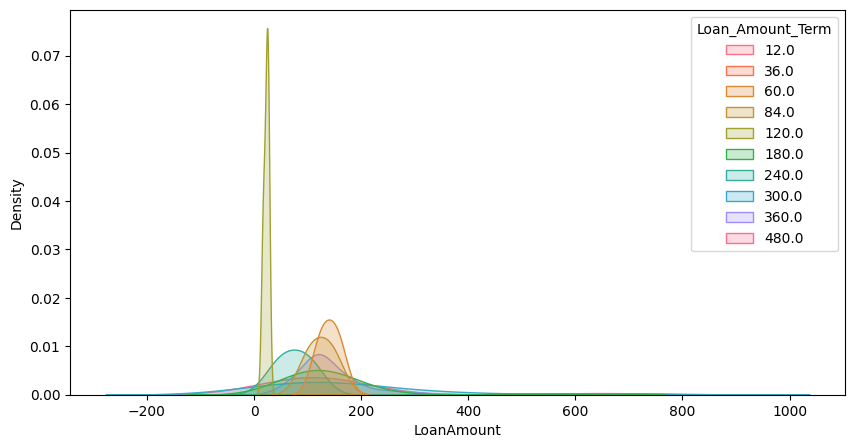

In [9]:
plt.figure(figsize=(10, 5))

sns.kdeplot(data=data, x='LoanAmount', hue='Loan_Amount_Term', fill=True, warn_singular=False, common_norm=False, palette="husl")
plt.show()

We can see that the trend that the higher the loan, it tend to have longer term, while the lower loan tend to have shorter term

### Distribution of loan amount

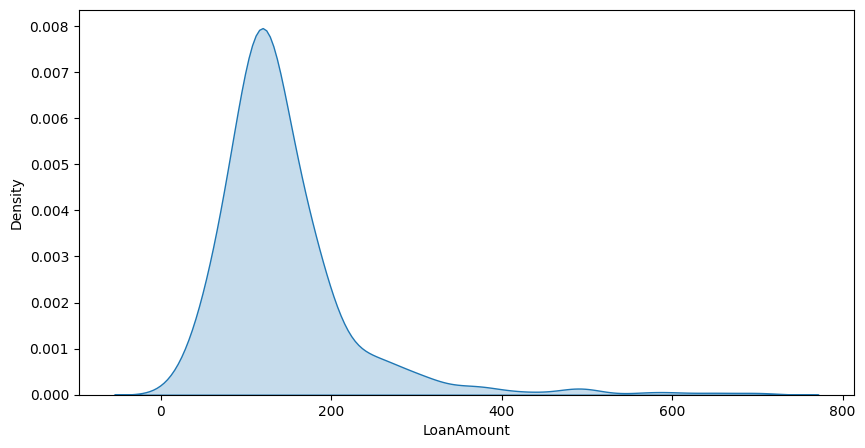

In [10]:
plt.figure(figsize=(10, 5))

sns.kdeplot(data=data, x='LoanAmount', fill=True, common_norm=False)
plt.show()


Most of the applicant apply loan at aroun 180USD

### Distribution of Loan Status based on Income

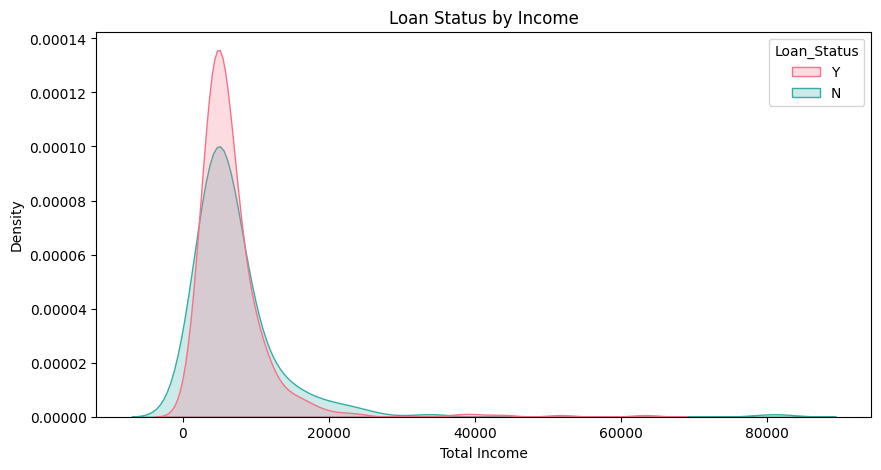

In [11]:
plt.figure(figsize=(10, 5))

sns.kdeplot(data=data, x='Total_Income', hue="Loan_Status", fill=True, common_norm=False, palette="husl")

plt.title('Loan Status by Income')
plt.xlabel('Total Income')
plt.ylabel('Density')

plt.show()

Most of the applicant have Total Income around 10k USD

### Loan Status by property area

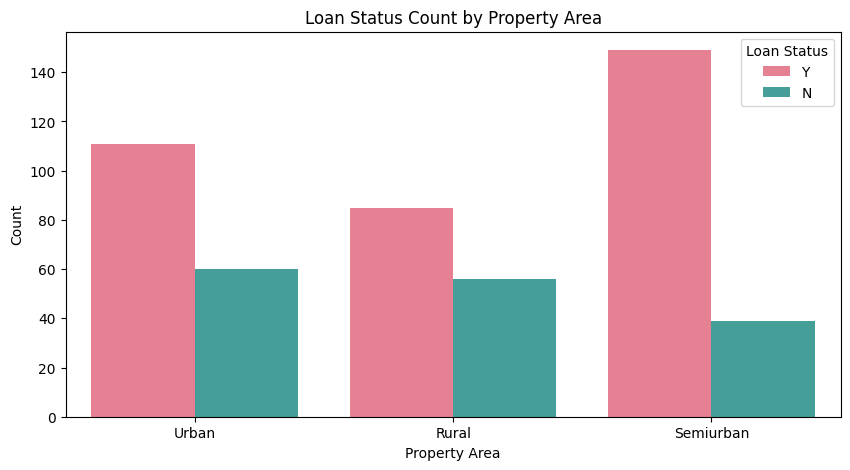

In [12]:
plt.figure(figsize=(10, 5))

sns.countplot(x='Property_Area', hue='Loan_Status', data=data, palette='husl')

plt.title('Loan Status Count by Property Area')
plt.legend(title='Loan Status', loc='upper right')
plt.xlabel('Property Area')
plt.ylabel('Count')

plt.show()

By seeing the distribution above, it's more likely that loan application is accepted when the applicant live in `Semiurban` area

### Distribution of loan Status based on marriage status

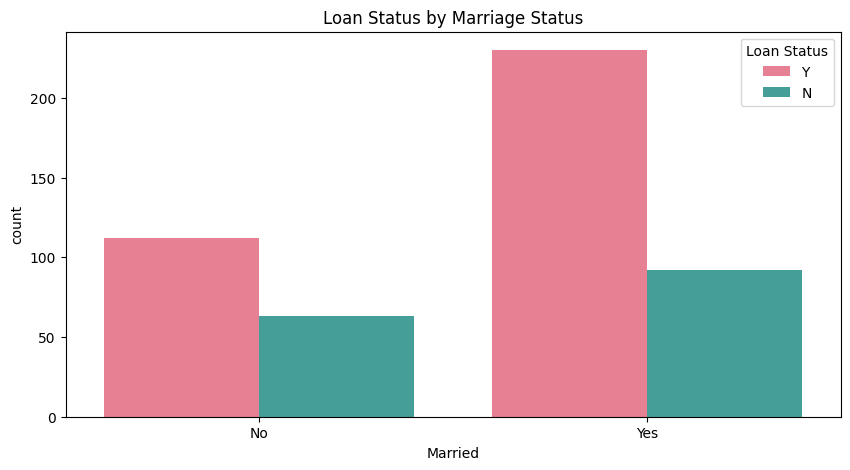

In [13]:
plt.figure(figsize=(10, 5))

sns.countplot(x='Married', hue='Loan_Status', data=data, palette='husl')

plt.title('Loan Status by Marriage Status')
plt.legend(title='Loan Status', loc='upper right')
plt.show()

### Distribution of loan Status based on education

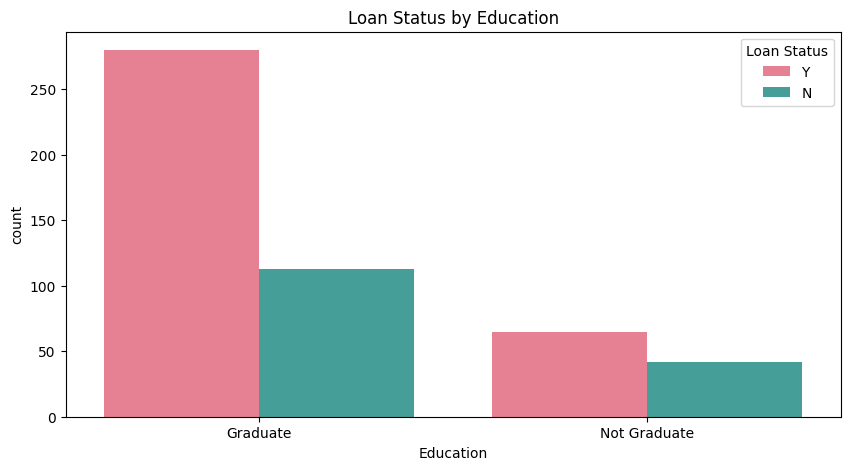

In [14]:
plt.figure(figsize=(10, 5))

sns.countplot(x='Education', hue='Loan_Status', data=data, palette='husl')

plt.title('Loan Status by Education')
plt.legend(title='Loan Status', loc='upper right')
plt.show()

### Distribution of loan status based on how many dependent the applicant have

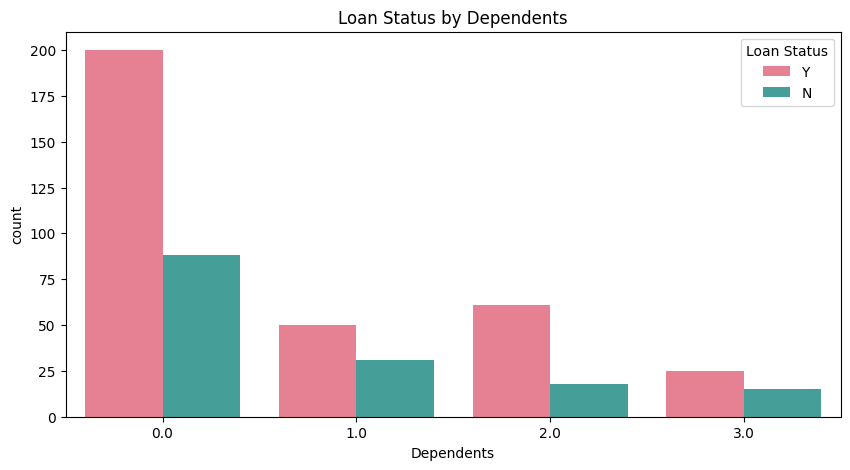

In [15]:
plt.figure(figsize=(10, 5))

sns.countplot(x='Dependents', hue='Loan_Status', data=data, palette='husl')

plt.title('Loan Status by Dependents')
plt.legend(title='Loan Status', loc='upper right')
plt.show()

Most of the apllicant doesn't have someone depent on them, and it's more likely the loan to be aprroved when they got no dependent

## Feature Engineering

In [16]:
data_fe = data.copy()

We will map Loan_status as Y = 1, N = 0 before further processing

In [17]:
data_fe.Loan_Status = data_fe.Loan_Status.map({'Y': 1, 'N': 0})

### Feature selection

- We will drop column `Unnamed 0` because this is likely index column;
- We will drop `Loan_id` because this is only the ID of loan so it won't have influence on the prediction model;
- We will drop `ApplicantIncome` and `CoapplicantIncome` to make the data have a less column because this information already stored in `Total_income` column.

In [18]:
data_fe.drop(['Unnamed: 0', 'Loan_ID'], axis=1, inplace=True)
data_fe.drop(['ApplicantIncome', 'CoapplicantIncome'], axis=1, inplace=True)

### Train test split

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data_fe.drop('Loan_Status', axis=1), data_fe['Loan_Status'], test_size=0.2, random_state=46)

### Missing value handling

In [20]:
x_train.isna().sum()

Gender               6
Married              2
Dependents          11
Education            0
Self_Employed       26
LoanAmount          12
Loan_Amount_Term     9
Credit_History      36
Property_Area        0
Total_Income         0
dtype: int64

There are some missing value, we will proceed with assumption as follow :
- Gender : Missing completely at random, we will fill it with mode;
- Married : Missing completely at random, we will fill it with mode;
- Dependents : Missing completely at random, we will fill it with 0, assuming the customer doesn't have dependents so they didn't fill it;
- Self-empoyed : Missing completely at random, we will fill it with mode;
- LoanAmount : Missing completely at random, we will fill it with median;
- Loan_Amount_Term : Missing completely at random, we will fill it with median;
- Credit_history : Missing completely at random, we will fill it with 0, assuming the customer doesn't have credit history so they didn't fill it;

In [21]:
x_train.Gender = x_train.Gender.fillna(x_train.Gender.mode()[0])
x_train.Married = x_train.Married.fillna(x_train.Married.mode()[0])
x_train.Dependents = x_train.Dependents.fillna(0)
x_train.Self_Employed = x_train.Self_Employed.fillna(x_train.Self_Employed.mode()[0])
x_train.LoanAmount = x_train.LoanAmount.fillna(x_train.LoanAmount.median())
x_train.Loan_Amount_Term = x_train.Loan_Amount_Term.fillna(x_train.Loan_Amount_Term.median())
x_train.Credit_History = x_train.Credit_History.fillna(0)

In [22]:
x_train.isna().sum()

Gender              0
Married             0
Dependents          0
Education           0
Self_Employed       0
LoanAmount          0
Loan_Amount_Term    0
Credit_History      0
Property_Area       0
Total_Income        0
dtype: int64

Check for X test

In [23]:
x_test.isna().sum()

Gender              3
Married             1
Dependents          1
Education           0
Self_Employed       1
LoanAmount          6
Loan_Amount_Term    5
Credit_History      5
Property_Area       0
Total_Income        0
dtype: int64

We will drop the row with missing value and it's repective value in y_test

In [24]:
y_test = y_test.drop(x_test[x_test.isna().any(axis=1)].index)
x_test = x_test.dropna()

### Outlier handling

We won't do any outlier handling, we want the data as it is. Because we want to have the data to mirror the real condition of the customer, for example if we treat someone with really high income as and outlier and trim his income to the upper bound, it will really impact the decision if it's seen by human.

### Scaling and encoding

In [25]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 12 to 189
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            400 non-null    object 
 1   Married           400 non-null    object 
 2   Dependents        400 non-null    float64
 3   Education         400 non-null    object 
 4   Self_Employed     400 non-null    object 
 5   LoanAmount        400 non-null    float64
 6   Loan_Amount_Term  400 non-null    float64
 7   Credit_History    400 non-null    float64
 8   Property_Area     400 non-null    object 
 9   Total_Income      400 non-null    float64
dtypes: float64(5), object(5)
memory usage: 34.4+ KB


- Categorical data are : Gender, Married, Education, Self_Employed, Property_Area
- Numerical data are : Dependents, LoanAmount, Loan_Amount_Term, Credit_History, Total_Income

In [26]:
categorical_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
numerical_cols = ['Dependents', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Total_Income']

In [27]:
x_train_cat = x_train[categorical_cols]
x_train_num = x_train[numerical_cols]

x_test_cat = x_test[categorical_cols]
x_test_num = x_test[numerical_cols]

In [28]:
scaler = MinMaxScaler()
scaler.fit(x_train_num)

x_train_num_scaled = scaler.transform(x_train_num)
X_test_num_scaled = scaler.transform(x_test_num)

In [29]:
for col in categorical_cols:
    print(col, x_train_cat[col].unique())

Gender ['Male' 'Female']
Married ['Yes' 'No']
Education ['Graduate' 'Not Graduate']
Self_Employed ['No' 'Yes']
Property_Area ['Urban' 'Semiurban' 'Rural']


We will encode as follow using ordinalEncoder:
- Gender → Male : 0, Female : 1;
- Married → Yes : 1, No : 0;
- Education → Graduate : 1, Not Graduate : 0;
- Self Employed → Yes : 1, No : 0;
- Property Area → Rural : 0, Semiurban : 1, Urban : 1.

In [30]:
encoder = OrdinalEncoder(categories = [['Male', 'Female'],
                                       ['No', 'Yes'],
                                       ['Not Graduate', 'Graduate'],
                                       ['No', 'Yes'],
                                       ['Rural', 'Semiurban', 'Urban']]
                         )
encoder.fit(x_train_cat)

x_train_cat_encoded = encoder.transform(x_train_cat)
x_test_cat_encoded = encoder.transform(x_test_cat)

Concat the data

In [31]:
x_train_cat_encoded

array([[0., 1., 1., 0., 2.],
       [0., 0., 1., 0., 2.],
       [0., 1., 1., 0., 2.],
       ...,
       [0., 0., 1., 0., 2.],
       [0., 1., 1., 1., 0.],
       [0., 1., 1., 0., 0.]])

In [32]:
x_train_final = np.concatenate([x_train_num_scaled, x_train_cat_encoded], axis = 1)
x_test_final = np.concatenate([X_test_num_scaled, x_test_cat_encoded], axis = 1)

## Model training

### KNN

In [33]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(x_train_final, y_train)

KNeighborsClassifier()

### SVM

In [34]:
svm = SVC(kernel='rbf', probability=True, random_state = 46)
svm.fit(x_train_final, y_train)

SVC(probability=True, random_state=46)

### Boosting

In [35]:
ada = AdaBoostClassifier(
    SVC(kernel='rbf', probability=True, random_state=46),
    n_estimators=500,
    random_state=46)

ada.fit(x_train_final, y_train)

AdaBoostClassifier(estimator=SVC(probability=True, random_state=46),
                   n_estimators=500, random_state=46)

### Decision Tree

In [36]:
dt = DecisionTreeClassifier(max_depth=6, random_state=46)
dt.fit(x_train_final, y_train)

DecisionTreeClassifier(max_depth=6, random_state=46)

### Random Forest

In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_cols),
        ('cat', encoder, categorical_cols)
    ])

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=46))])

In [38]:
param_pipe = {
    'classifier__n_estimators' : [1, 10, 100],
    'classifier__max_depth' : np.arange(4, 8, 1)
}

param_pipe = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 4, 6]
}

pipe_rf_gridcv = GridSearchCV(estimator=rf_pipeline,
                         param_grid = param_pipe,
                         cv=5,
                         n_jobs=-1,
                         verbose=2,
                         scoring='recall')

pipe_rf_gridcv.fit(x_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Dependents',
                                                                          'LoanAmount',
                                                                          'Loan_Amount_Term',
                                                                          'Credit_History',
                                                                          'Total_Income']),
                                                                        ('cat',
                                                                         OrdinalEncoder(categories=[['Male',
                                                                                                     'Female'],
                                                                                                    ['No',
                                                                                                     'Yes'],
                                                                                                    ['Not '
                                                                                                     'Graduate',
                                                                                                     'Graduate'],
                                                                                                    ['No',
                                                                                                     'Yes'],
                                                                                                    ['Rural',
                                                                                                     'Semiurban',
                                                                                                     'Urban']]),
                                                                         ['Gender',
                                                                          'Married',
                                                                          'Education',
                                                                          'Self_Employed',
                                                                          'Property_Area'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=46))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, 30],
                         'classifier__min_samples_split': [2, 4, 6],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='recall', verbose=2)

In [39]:
pipe_rf_best = pipe_rf_gridcv.best_estimator_

## Model Evaluation

### KNN

In [40]:
y_pred_knn = knn.predict(x_test_final)

print('Recall Score - Test Set   : ', recall_score(y_test, y_pred_knn), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_knn), '\n')

Recall Score - Test Set   :  0.9649122807017544 

Classification Report : 
               precision    recall  f1-score   support

           0       0.71      0.22      0.33        23
           1       0.75      0.96      0.85        57

    accuracy                           0.75        80
   macro avg       0.73      0.59      0.59        80
weighted avg       0.74      0.75      0.70        80
 



We recall score of 96% at test set, we focuses to get all Positive prediction even it's false positive, so this score is quite High

### SVM

In [41]:
y_pred_svm = svm.predict(x_test_final)

print('Recall Score - Test Set   : ', recall_score(y_test, y_pred_svm), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_svm), '\n')

Recall Score - Test Set   :  0.9824561403508771 

Classification Report : 
               precision    recall  f1-score   support

           0       0.89      0.35      0.50        23
           1       0.79      0.98      0.88        57

    accuracy                           0.80        80
   macro avg       0.84      0.67      0.69        80
weighted avg       0.82      0.80      0.77        80
 



We recall score of 98% at test set, we focuses to get all Positive prediction even it's false positive, so this score is High.

### Boosting

In [42]:
y_pred_boost = ada.predict(x_test_final)

print('Recall Score - Test Set   : ', recall_score(y_test, y_pred_boost), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_boost, labels=np.unique(y_pred_boost)), '\n')

Recall Score - Test Set   :  1.0 

Classification Report : 
               precision    recall  f1-score   support

           1       0.71      1.00      0.83        57

   micro avg       0.71      1.00      0.83        57
   macro avg       0.71      1.00      0.83        57
weighted avg       0.71      1.00      0.83        57
 



The model overfit really hard, it only predict class 1 without predicting class 0, so it's really bad

### Random Forest pipeline

In [43]:
y_pred_rfp = pipe_rf_best.predict(x_test)

print('Recall Score - Test Set   : ', recall_score(y_test, y_pred_rfp), '\n')
print('Classification Report : \n', classification_report(y_test, y_pred_rfp), '\n')

Recall Score - Test Set   :  0.9473684210526315 

Classification Report : 
               precision    recall  f1-score   support

           0       0.75      0.39      0.51        23
           1       0.79      0.95      0.86        57

    accuracy                           0.79        80
   macro avg       0.77      0.67      0.69        80
weighted avg       0.78      0.79      0.76        80
 



We recall score of 94% at test set, we focuses to get all Positive prediction even it's false positive, so this score is quite High

### Cross validation

In [44]:
knn_cv_result = cross_validate(knn, x_train_final, y_train, cv=5, scoring='recall')
svm_cv_result = cross_validate(svm, x_train_final, y_train, cv=5, scoring='recall')
ada_cv_result = cross_validate(ada, x_train_final, y_train, cv=5, scoring='recall')
rfp_cv_result = cross_validate(pipe_rf_best, x_train, y_train, cv=5, scoring='recall')

In [45]:
print(f'KNN Recall Score : {np.mean(knn_cv_result["test_score"]):.4f}')
print(f'SVM Recall Score : {np.mean(svm_cv_result["test_score"]):.4f}')
print(f'AdaBoost Recall Score : {np.mean(ada_cv_result["test_score"]):.4f}')
print(f'Random Forest Pipeline Recall Score : {np.mean(rfp_cv_result["test_score"]):.4f}')

KNN Recall Score : 0.8796
SVM Recall Score : 0.8869
AdaBoost Recall Score : 1.0000
Random Forest Pipeline Recall Score : 0.8904


We will save and use Random Forest model, because it have the bigger score on Cross Validation, why don't we use AdaBoost, because we already see before, the model didn't predict class 0 at all, and likely will predict all input into class 1

## Model Saving

In [46]:
pickle.dump(pipe_rf_best, open('model_rf.pkl', 'wb'))

## Conclusion

The model performed quite good to predict whether customer is approved or not when applying for loan, it reach our objective to make a model to filter the application by machine before checked by human agent. We can make our model better with more training data in the future.